# 🧠 Project Overview

This project analyzes employee attrition using the **IBM HR Analytics** dataset.  
It simulates a real-world **People Analytics workflow** by combining:

- **SQL (via DuckDB)** for structured exploration and slicing
- **Python** (`pandas`, `seaborn`, `scikit-learn`) for predictive modeling and data visualization

The goal is to uncover key drivers of attrition and generate actionable HR insights to improve retention, compensation fairness, and workforce strategy.

# Executive Summary
Workforce & Compensation Insights
Analysis of employee demographics, compensation distribution, and attrition patterns, using the IBM HR dataset as a proxy.

# Headline Metrics

Metric                                   | Value      |
|------------------------------------------|------------|
| Total Employees                          | 1,470      |
| Attrition Rate                           | 16.1%      |
| Median Monthly Income                    | $5,000     |
| Departments with Highest Attrition       | Sales (20.3%), R&D (18.5%) |
| Avg Pay Gap (Male vs. Female)            | $450/month |
| % High Performers at Retention Risk      | 14%        |

3. Key Findings
Short bullet points (1 sentence each) for your top insights.

Example:

Attrition is concentrated in Sales and R&D, primarily among employees with 2–5 years tenure and frequent overtime.

Compensation gaps exist at certain job levels, with male employees earning slightly more on average in the same roles.

Work-life balance ratings are significantly lower for overtime workers, correlating with higher attrition risk.

High performers with stagnant promotion histories represent the largest retention risk.



4. Recommended Actions
Frame them as business decisions, not just data points.

Example:

Review pay equity for mid-level technical roles, particularly in R&D.

Targeted retention program for Sales associates with 2–5 years tenure.

Reduce overtime reliance by redistributing workload across teams.

Implement quarterly career growth check-ins for top performers.

## Read in the data

In [2]:
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Load dataset
df = pd.read_csv('../data/emp_attrition.csv')

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# Validation
Verified there is no missing data in the dataset.

In [48]:
# Count NULLs by column
null_counts = df.isnull().sum()

# Show only columns with missing values
null_counts[null_counts > 0]

Series([], dtype: int64)

In [49]:
duplicate_count = df.duplicated().sum()
duplicate_count

np.int64(0)

In [50]:
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")

Attrition: ['Yes' 'No']
BusinessTravel: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department: ['Sales' 'Research & Development' 'Human Resources']
EducationField: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender: ['Female' 'Male']
JobRole: ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
MaritalStatus: ['Single' 'Married' 'Divorced']
Over18: ['Y']
OverTime: ['Yes' 'No']


In [51]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [52]:
df['Attrition'].value_counts(dropna=False)

Attrition
No     1233
Yes     237
Name: count, dtype: int64

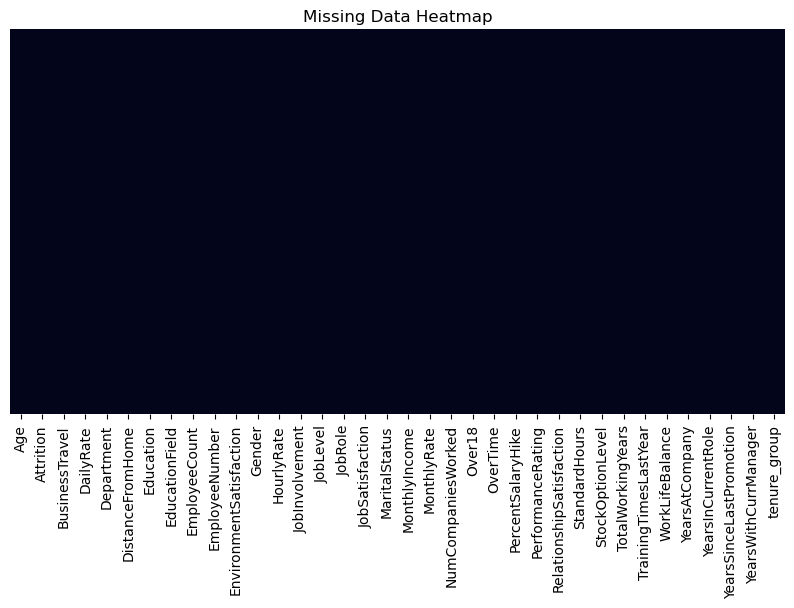

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()

## Column Names

In [3]:
list(df.columns)

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

## For SQL Use

In [4]:
# Connect DuckDB in memory
con = duckdb.connect(database=':memory:')

# Register DataFrame as SQL table
con.register('employees', df)

# Workforce Demographic Breakdown

## By Gender

In [5]:
con.execute("""
    SELECT 
        Gender,
        COUNT(*) AS employee_count,
        ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM employees), 2) AS percentage
    FROM employees
    GROUP BY Gender
""").df()

,Gender,employee_count,percentage
0,Female,588,40.0
1,Male,882,60.0


## By Department

In [6]:
con.execute("""
    SELECT 
        Department,
        COUNT(*) AS employee_count,
        ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM employees), 2) AS percentage
    FROM employees
    GROUP BY Department
""").df()

,Department,employee_count,percentage
0,Research & Development,961,65.37
1,Sales,446,30.34
2,Human Resources,63,4.29


## By Education Field

In [7]:
con.execute("""
    SELECT 
        EducationField,
        COUNT(*) AS employee_count,
        ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM employees), 2) AS percentage
    FROM employees
    GROUP BY EducationField
""").df()

,EducationField,employee_count,percentage
0,Marketing,159,10.82
1,Life Sciences,606,41.22
2,Other,82,5.58
3,Medical,464,31.56
4,Technical Degree,132,8.98
5,Human Resources,27,1.84


## By Age Group

In [8]:
con.execute("""
    SELECT 
        CASE 
            WHEN Age < 30 THEN '<30'
            WHEN Age BETWEEN 30 AND 39 THEN '30-39'
            WHEN Age BETWEEN 40 AND 49 THEN '40-49'
            ELSE '50+'
        END AS age_group,
        COUNT(*) AS employee_count,
        ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM employees), 2) AS percentage
    FROM employees
    GROUP BY age_group
    ORDER BY age_group
""").df()

,age_group,employee_count,percentage
0,30-39,622,42.31
1,40-49,349,23.74
2,50+,173,11.77
3,<30,326,22.18


# Visual Breakdowns

/var/folders/sd/62hmd4jj3wz0p8km2qnyqgj80000gn/T/ipykernel_1907/342466881.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Gender', palette='pastel')


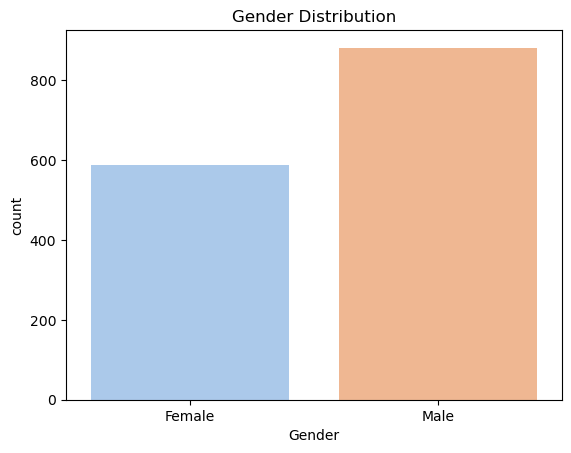

In [9]:
sns.countplot(data=df, x='Gender', palette='pastel')
plt.title('Gender Distribution')
plt.show()

/var/folders/sd/62hmd4jj3wz0p8km2qnyqgj80000gn/T/ipykernel_1907/3687383681.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Department', palette='muted', order=df['Department'].value_counts().index)


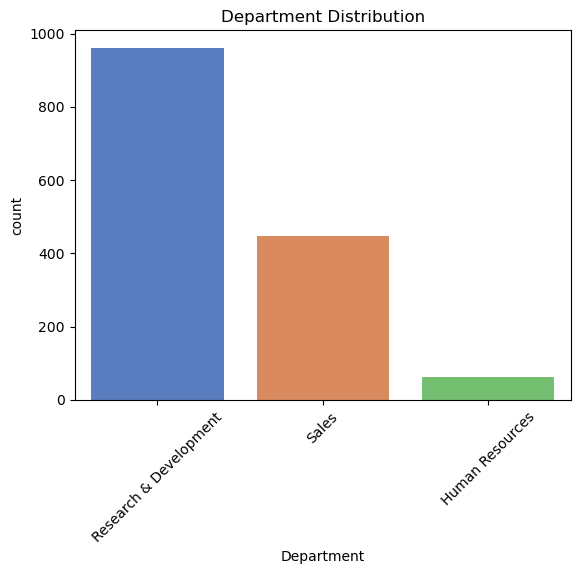

In [10]:
sns.countplot(data=df, x='Department', palette='muted', order=df['Department'].value_counts().index)
plt.title('Department Distribution')
plt.xticks(rotation=45)
plt.show()

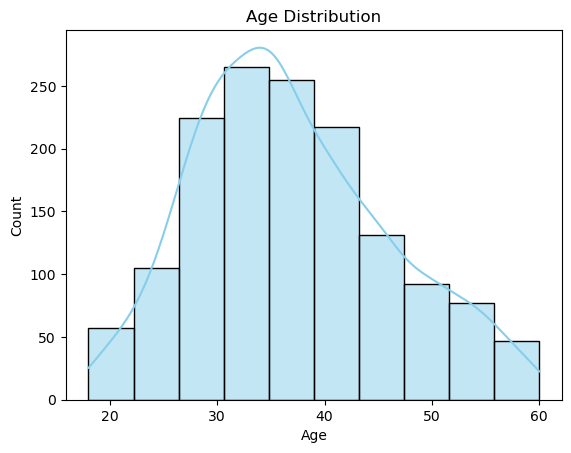

In [11]:
sns.histplot(data=df, x='Age', bins=10, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.show()

## Tenure & Career Stage
Purpose: Show how long employees tend to stay and where attrition spikes.

Attrition spikes for lower tenured groups. Interestingly the groups between 6-10 years has a higher attrition rate. This could be indicative of less room for development the more senior you get or not enough LTI or compensation the further along you progress. This is supported below.

In [36]:
con.execute("""
    SELECT 
        CASE 
            WHEN YearsAtCompany < 2 THEN '<2 years'
            WHEN YearsAtCompany BETWEEN 2 AND 5 THEN '2-5 years'
            WHEN YearsAtCompany BETWEEN 6 AND 10 THEN '6-10 years'
            ELSE '10+ years'
        END AS tenure_group,
        COUNT(*) AS total_employees,
        ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM employees), 2) AS percentage,
        ROUND(100.0 * SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS attrition_rate
    FROM employees
    GROUP BY tenure_group
    ORDER BY tenure_group
""").df()

,tenure_group,total_employees,percentage,attrition_rate
0,10+ years,246,16.73,8.13
1,2-5 years,561,38.16,15.51
2,6-10 years,448,30.48,12.28
3,<2 years,215,14.63,34.88


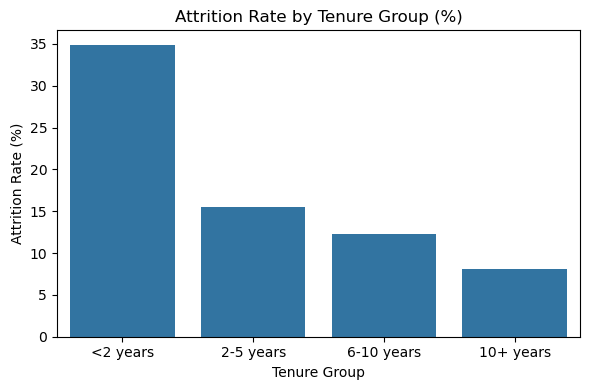

In [40]:
# Step 1: Create tenure groups
df['tenure_group'] = pd.cut(
    df['YearsAtCompany'],
    bins=[-1, 1, 5, 10, df['YearsAtCompany'].max()],
    labels=['<2 years', '2-5 years', '6-10 years', '10+ years']
)

# Step 2: Compute attrition rate by tenure group
tenure_attr = (
    pd.crosstab(df['tenure_group'], df['Attrition'], normalize='index') * 100
).reset_index()

tenure_attr = tenure_attr.rename(columns={'Yes': 'AttritionRate'})
tenure_attr = tenure_attr[['tenure_group', 'AttritionRate']]

# Step 3: Plot the bar chart
plt.figure(figsize=(6, 4))
sns.barplot(data=tenure_attr, x='tenure_group', y='AttritionRate')
plt.title('Attrition Rate by Tenure Group (%)')
plt.ylabel('Attrition Rate (%)')
plt.xlabel('Tenure Group')
plt.tight_layout()
plt.show()

Early tenure (<2 years → 2–5 years): Small bump (~+700), likely driven by small promotions or merit raises.

Mid tenure (2–5 years → 6–10 years): Larger bump (~+1,300), possibly due to hitting higher job levels.

Plateau effect (6–10 years): Big gap before the massive jump at 10+ years (~+4,300), likely due to reaching senior or executive roles that pay significantly more.

In [38]:
con.execute("""
    SELECT 
        CASE 
            WHEN YearsAtCompany < 2 THEN '<2 years'
            WHEN YearsAtCompany BETWEEN 2 AND 5 THEN '2-5 years'
            WHEN YearsAtCompany BETWEEN 6 AND 10 THEN '6-10 years'
            ELSE '10+ years'
        END AS tenure_group,
        ROUND(AVG(MonthlyIncome), 0) AS avg_income
    FROM employees
    GROUP BY tenure_group
    ORDER BY 
        CASE tenure_group 
            WHEN '<2 years' THEN 1
            WHEN '2-5 years' THEN 2
            WHEN '6-10 years' THEN 3
            ELSE 4
        END
""").df()


,tenure_group,avg_income
0,<2 years,4565.0
1,2-5 years,5272.0
2,6-10 years,6567.0
3,10+ years,10887.0


## Overtime & Workload
Purpose: Identify if overwork is linked to attrition.

Overtime is associated with much more attrition. Almost a 3x leave rate.

In [13]:
con.execute("""
    SELECT 
        OverTime,
        COUNT(*) AS total_employees,
        SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) AS leavers,
        ROUND(100.0 * SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS attrition_rate
    FROM employees
    GROUP BY OverTime
""").df()

,OverTime,total_employees,leavers,attrition_rate
0,No,1054,110.0,10.44
1,Yes,416,127.0,30.53


/var/folders/sd/62hmd4jj3wz0p8km2qnyqgj80000gn/T/ipykernel_1907/2226093570.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=overtime_attr, x='OverTime', y='percentage', palette='pastel')


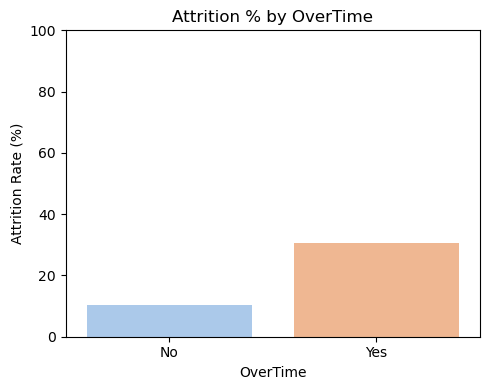

In [43]:
# Calculate percent attrition by OverTime
overtime_attr = (
    df.groupby('OverTime')['Attrition']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
)

# Filter only 'Yes' for attrition
overtime_attr = overtime_attr[overtime_attr['Attrition'] == 'Yes']

# Plot
plt.figure(figsize=(5,4))
sns.barplot(data=overtime_attr, x='OverTime', y='percentage', palette='pastel')
plt.title('Attrition % by OverTime')
plt.xlabel('OverTime')
plt.ylabel('Attrition Rate (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

## Compensation Distribution
Purpose: Show income spread by role and department.

In [14]:
con.execute("""
    SELECT 
        Department,
        ROUND(AVG(MonthlyIncome), 2) AS avg_income,
        MIN(MonthlyIncome) AS min_income,
        MAX(MonthlyIncome) AS max_income
    FROM employees
    GROUP BY Department
    ORDER BY avg_income DESC
""").df()

,Department,avg_income,min_income,max_income
0,Sales,6959.17,1052,19847
1,Human Resources,6654.51,1555,19717
2,Research & Development,6281.25,1009,19999


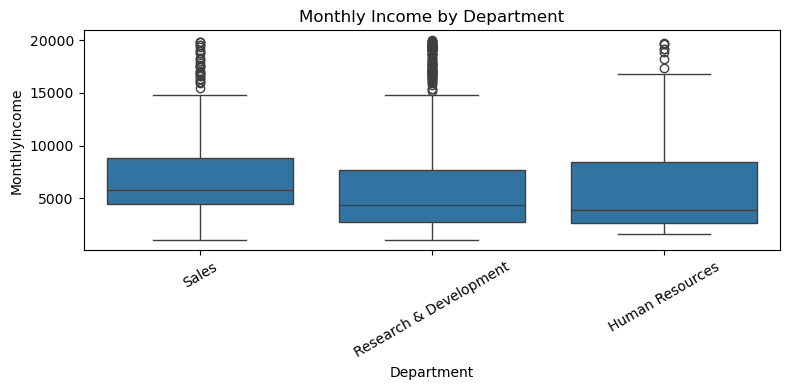

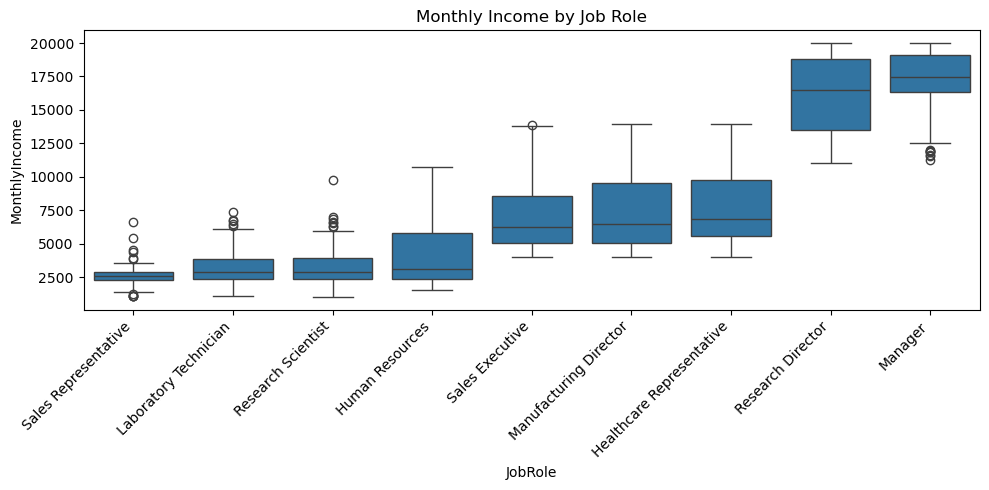

In [44]:
# by Department
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='Department', y='MonthlyIncome')
plt.title('Monthly Income by Department')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# by JobRole (can be wide; sort by median to help readability)
order_roles = df.groupby('JobRole')['MonthlyIncome'].median().sort_values().index
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='JobRole', y='MonthlyIncome', order=order_roles)
plt.title('Monthly Income by Job Role')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Job Satisfaction & Engagement
Purpose: Show how satisfaction correlates with attrition.

In [15]:
con.execute("""
    SELECT 
        JobSatisfaction,
        COUNT(*) AS total_employees,
        ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM employees), 2) AS percentage,
        ROUND(100.0 * SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS attrition_rate
    FROM employees
    GROUP BY JobSatisfaction
    ORDER BY JobSatisfaction DESC
""").df()

,JobSatisfaction,total_employees,percentage,attrition_rate
0,4,459,31.22,11.33
1,3,442,30.07,16.52
2,2,280,19.05,16.43
3,1,289,19.66,22.84


/var/folders/sd/62hmd4jj3wz0p8km2qnyqgj80000gn/T/ipykernel_1907/1513975037.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=js_attr, x='JobSatisfaction', y='percentage', palette='pastel')


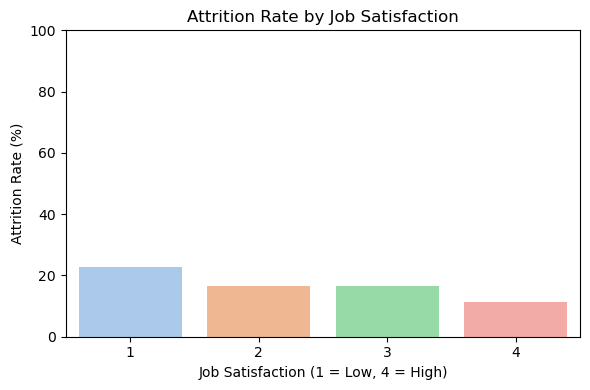

In [46]:
# Calculate attrition percentage by JobSatisfaction
js_attr = (
    df.groupby('JobSatisfaction')['Attrition']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
)

# Keep only leavers
js_attr = js_attr[js_attr['Attrition'] == 'Yes']

# Plot percentage
plt.figure(figsize=(6,4))
sns.barplot(data=js_attr, x='JobSatisfaction', y='percentage', palette='pastel')
plt.title('Attrition Rate by Job Satisfaction')
plt.xlabel('Job Satisfaction (1 = Low, 4 = High)')
plt.ylabel('Attrition Rate (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

## Cross-Tabs for Combined Risk Factors

In [33]:
def attrition_crosstab(df, col):
    ct = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
    ct = ct.round(2)
    ct['n'] = df.groupby(col)['Attrition'].count()
    return ct

def attrition_crosstab_multi(df, cols):
    ct = pd.crosstab(index=[df[c] for c in cols], columns=df['Attrition'], normalize='index') * 100
    ct = ct.round(2)
    ct['n'] = df.groupby(cols)['Attrition'].count()
    return ct

Attrition                     No    Yes    n
JobLevel WorkLifeBalance                    
1        1                 51.43  48.57   35
         2                 76.30  23.70  135
         3                 76.78  23.22  323
         4                 62.00  38.00   50
2        1                 81.48  18.52   27
         2                 88.14  11.86  118
         3                 91.49   8.51  329
         4                 91.67   8.33   60
3        1                 83.33  16.67   12
         2                 80.43  19.57   46
         3                 86.67  13.33  135
         4                 88.00  12.00   25
4        1                 80.00  20.00    5
         2                 89.66  10.34   29
         3                 98.36   1.64   61
         4                100.00   0.00   11
5        1                100.00   0.00    1
         2                100.00   0.00   16
         3                 88.89  11.11   45
         4                100.00   0.00    7

## Work conditions and workload

People that travel more are more likely to leave

In [17]:
attrition_crosstab(df, 'BusinessTravel')

Attrition,No,Yes,n
BusinessTravel,,,
Non-Travel,92.00,8.00,150
Travel_Frequently,75.09,24.91,277
Travel_Rarely,85.04,14.96,1043


The less involved you are in your job, the more likely you are to leave

In [18]:
attrition_crosstab(df, 'JobInvolvement')

Attrition,No,Yes,n
JobInvolvement,,,
1,66.27,33.73,83
2,81.07,18.93,375
3,85.60,14.40,868
4,90.97,9.03,144


The better your worklife balance, the more likely you are to stay. Interestingly though, people within the range of 2-3 are reversed, maybe signaling a similar load of work between these levels

In [19]:
attrition_crosstab(df, 'WorkLifeBalance')

Attrition,No,Yes,n
WorkLifeBalance,,,
1,68.75,31.25,80
2,83.14,16.86,344
3,85.78,14.22,893
4,82.35,17.65,153


## Career stage and progression

The lower your job level, the bigger chance you have of leaving. Surpsingly, level 3 spikes and upon further review below, it's because job satisfaction decreases from role 2 -> 3

In [20]:
attrition_crosstab(df, 'JobLevel')

Attrition,No,Yes,n
JobLevel,,,
1,73.66,26.34,543
2,90.26,9.74,534
3,85.32,14.68,218
4,95.28,4.72,106
5,92.75,7.25,69


In [35]:
attrition_crosstab_multi(df, ['JobLevel', 'WorkLifeBalance'])

Attrition                     No    Yes    n
JobLevel WorkLifeBalance                    
1        1                 51.43  48.57   35
         2                 76.30  23.70  135
         3                 76.78  23.22  323
         4                 62.00  38.00   50
2        1                 81.48  18.52   27
         2                 88.14  11.86  118
         3                 91.49   8.51  329
         4                 91.67   8.33   60
3        1                 83.33  16.67   12
         2                 80.43  19.57   46
         3                 86.67  13.33  135
         4                 88.00  12.00   25
4        1                 80.00  20.00    5
         2                 89.66  10.34   29
         3                 98.36   1.64   61
         4                100.00   0.00   11
5        1                100.00   0.00    1
         2                100.00   0.00   16
         3                 88.89  11.11   45
         4                100.00   0.00    7

Employees with 0–4 prior companies generally have lower attrition rates (~10–18%).

Attrition spikes for employees with 5–7 prior companies, with rates above 22–25%.

Interestingly, those with 8+ companies see a drop again (~12–23%), though the sample size (n) is small, so that could just be noise.

Interpretation:

This could indicate that people with a history of frequent job changes (job hopping) are more likely to leave, possibly due to lower organizational commitment or seeking better opportunities.

In [21]:
attrition_crosstab(df, 'NumCompaniesWorked')

Attrition,No,Yes,n
NumCompaniesWorked,,,
0,88.32,11.68,197
1,81.19,18.81,521
2,89.04,10.96,146
3,89.94,10.06,159
4,87.77,12.23,139
5,74.60,25.40,63
6,77.14,22.86,70
7,77.03,22.97,74
8,87.76,12.24,49


## Pay and rewards

In [22]:
attrition_crosstab(df, 'StockOptionLevel')

Attrition,No,Yes,n
StockOptionLevel,,,
0,75.59,24.41,631
1,90.60,9.40,596
2,92.41,7.59,158
3,82.35,17.65,85


In [23]:
attrition_crosstab(df, 'JobSatisfaction')

Attrition,No,Yes,n
JobSatisfaction,,,
1,77.16,22.84,289
2,83.57,16.43,280
3,83.48,16.52,442
4,88.67,11.33,459


In [24]:
attrition_crosstab(df, 'EnvironmentSatisfaction')

Attrition,No,Yes,n
EnvironmentSatisfaction,,,
1,74.65,25.35,284
2,85.02,14.98,287
3,86.31,13.69,453
4,86.55,13.45,446


In [25]:
attrition_crosstab(df, 'RelationshipSatisfaction')

Attrition,No,Yes,n
RelationshipSatisfaction,,,
1,79.35,20.65,276
2,85.15,14.85,303
3,84.53,15.47,459
4,85.19,14.81,432


## Performance Ratings
Purpose: See if high/low performers leave more often

In [26]:
attrition_crosstab(df, 'PerformanceRating')

Attrition,No,Yes,n
PerformanceRating,,,
3,83.92,16.08,1244
4,83.63,16.37,226


## Demographics

In [27]:
attrition_crosstab(df, 'Gender')

Attrition,No,Yes,n
Gender,,,
Female,85.20,14.80,588
Male,82.99,17.01,882


In [28]:
attrition_crosstab(df, 'MaritalStatus')

Attrition,No,Yes,n
MaritalStatus,,,
Divorced,89.91,10.09,327
Married,87.52,12.48,673
Single,74.47,25.53,470


# Attrition

## Attrition by Department

In [8]:
con.execute("""
    SELECT 
        Department,
        COUNT(*) AS total,
        SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) AS leavers,
        ROUND(100.0 * SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS attrition_rate
    FROM employees
    GROUP BY Department
    ORDER BY attrition_rate DESC
""").df()

,Department,total,leavers,attrition_rate
0,Sales,446,92.0,20.63
1,Human Resources,63,12.0,19.05
2,Research & Development,961,133.0,13.84


In [39]:
con.execute("""
    SELECT 
        JobRole,
        COUNT(*) AS total_employees,
        SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) AS leavers,
        ROUND(100.0 * SUM(CASE WHEN Attrition = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS attrition_rate
    FROM employees
    GROUP BY JobRole
    ORDER BY attrition_rate DESC
""").df()

,JobRole,total_employees,leavers,attrition_rate
0,Sales Representative,83,33.0,39.76
1,Laboratory Technician,259,62.0,23.94
2,Human Resources,52,12.0,23.08
3,Sales Executive,326,57.0,17.48
4,Research Scientist,292,47.0,16.10
5,Manufacturing Director,145,10.0,6.90
6,Healthcare Representative,131,9.0,6.87
7,Manager,102,5.0,4.90
8,Research Director,80,2.0,2.50


## Attrition Predictive Model

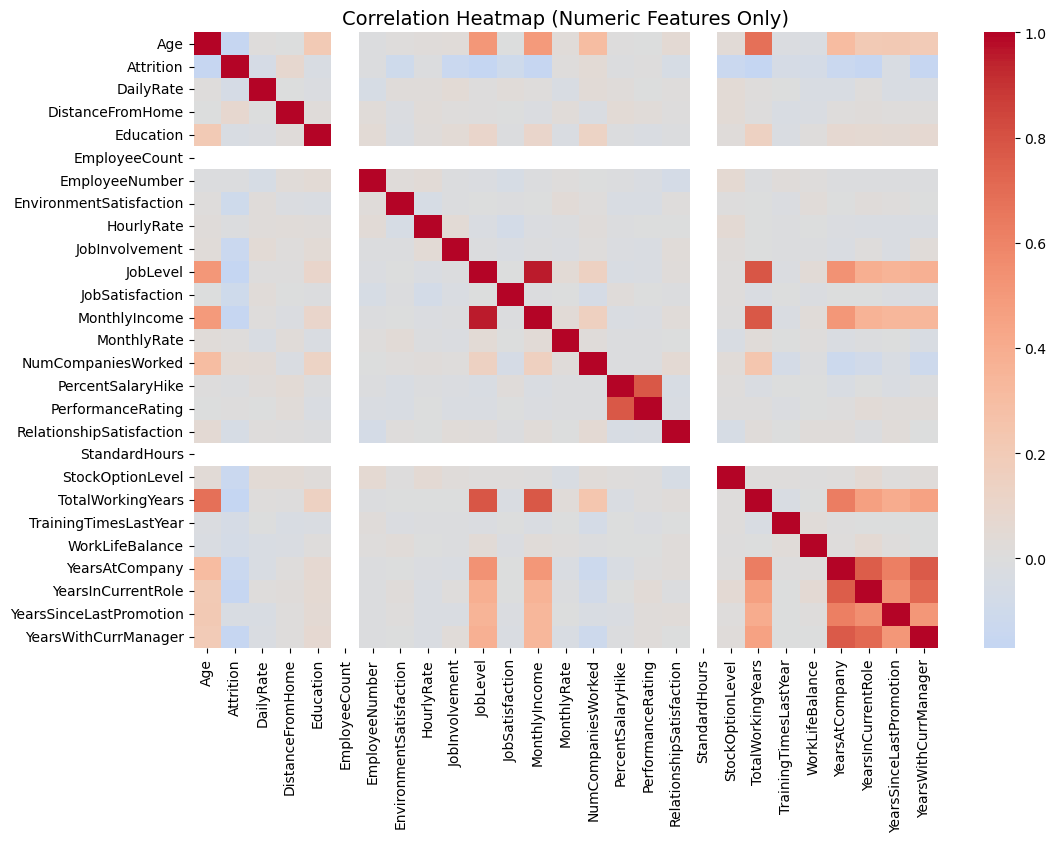

Attrition                   1.000000
DistanceFromHome            0.077924
NumCompaniesWorked          0.043494
MonthlyRate                 0.015170
PerformanceRating           0.002889
HourlyRate                 -0.006846
EmployeeNumber             -0.010577
PercentSalaryHike          -0.013478
Education                  -0.031373
YearsSinceLastPromotion    -0.033019
RelationshipSatisfaction   -0.045872
DailyRate                  -0.056652
TrainingTimesLastYear      -0.059478
WorkLifeBalance            -0.063939
EnvironmentSatisfaction    -0.103369
JobSatisfaction            -0.103481
JobInvolvement             -0.130016
YearsAtCompany             -0.134392
StockOptionLevel           -0.137145
YearsWithCurrManager       -0.156199
Age                        -0.159205
MonthlyIncome              -0.159840
YearsInCurrentRole         -0.160545
JobLevel                   -0.169105
TotalWorkingYears          -0.171063
EmployeeCount                    NaN
StandardHours                    NaN
N

In [64]:
# Copy DF & encode Attrition
df_num = df.copy()
df_num['Attrition'] = df_num['Attrition'].map({'Yes': 1, 'No': 0})

# Select numeric columns
numeric_cols = df_num.select_dtypes(include=['number']).columns

# Correlation matrix (numeric only)
corr_matrix_num = df_num[numeric_cols].corr()

# Plot heatmap without annotations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_num, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap (Numeric Features Only)', fontsize=14)
plt.show()

# Optional: print top correlations with Attrition separately
top_corr = corr_matrix_num['Attrition'].sort_values(ascending=False)
print(top_corr)

In [62]:
# One-hot encode categoricals
df_ohe = pd.get_dummies(df, drop_first=True)

# Map Attrition to numeric
df_ohe['Attrition'] = df_ohe['Attrition_Yes']  # created by get_dummies
df_ohe.drop(columns=['Attrition_Yes'], inplace=True)

# Full correlation matrix
corr_matrix_ohe = df_ohe.corr()

# Sort correlations with Attrition
top_corr = corr_matrix_ohe['Attrition'].sort_values(key=abs, ascending=False).drop('Attrition')
print(top_corr.head(15))  # Top 15 correlations

OverTime_Yes                        0.246118
MaritalStatus_Single                0.175419
TotalWorkingYears                  -0.171063
JobLevel                           -0.169105
YearsInCurrentRole                 -0.160545
MonthlyIncome                      -0.159840
Age                                -0.159205
JobRole_Sales Representative        0.157234
YearsWithCurrManager               -0.156199
StockOptionLevel                   -0.137145
YearsAtCompany                     -0.134392
JobInvolvement                     -0.130016
BusinessTravel_Travel_Frequently    0.115143
JobSatisfaction                    -0.103481
EnvironmentSatisfaction            -0.103369
Name: Attrition, dtype: float64


# Train/Test Split

## Encode Data
## **Data Preparation and Splitting**

## **Data Preparation Summary**

1. **Encode Target Variable**  
   - Convert `Attrition` from `"Yes"`/`"No"` to binary `1`/`0` for classification.

2. **One-Hot Encode Categorical Features**  
   - Use `pd.get_dummies` to convert categorical variables into numeric dummy variables (`drop_first=True` to avoid multicollinearity).

3. **Split Features and Target**  
   - `X` = predictors, `y` = target (`Attrition`).

4. **Train-Test Split**  
   - Split data into 80% train / 20% test using `train_test_split` with `stratify` to maintain class balance.

5. **Feature Scaling**  
   - Apply `StandardScaler` to standardize continuous features for models sensitive to feature scale (e.g., logistic regression).

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train Models & Compare Performance
## **Model Performance Summary**

### **Metric Definitions**
- **Precision:** Of all employees predicted to leave, how many actually left?  
- **Recall (Sensitivity):** Of all employees who actually left, how many did we correctly identify?  
- **F1 Score:** The harmonic mean of precision and recall, balancing both.  
- **ROC-AUC:** Area under the Receiver Operating Characteristic curve.  

---

### **Results Table**

| Model                  | Accuracy | Precision | Recall | F1 Score | ROC-AUC |
|------------------------|----------|-----------|--------|----------|---------|
| Logistic Regression    | 0.857    | 0.586     | 0.362  | 0.447    | 0.821   |
| Random Forest          | 0.830    | 0.364     | 0.085  | 0.138    | 0.783   |
| Gradient Boosting      | 0.854    | 0.611     | 0.234  | 0.338    | 0.802   |

---

### **Interpretation**
- **Logistic Regression** – Best recall, solid precision, strong ROC-AUC.  
- **Random Forest** – Low recall, meaning it misses most leavers.  
- **Gradient Boosting** – Highest precision, decent ROC-AUC, but still misses many leavers.  

---

**Business Takeaway:**  
If the goal is **to catch as many at-risk employees as possible**, choose **Logistic Regression**.  
If the goal is **to only flag those who are highly likely to leave**, choose **Gradient Boosting**.  

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = []

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results).set_index('Model')
results_df

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Model,,,,,
Logistic Regression,0.857143,0.586207,0.361702,0.447368,0.820743
Random Forest,0.829932,0.363636,0.085106,0.137931,0.782841
Gradient Boosting,0.853741,0.611111,0.234043,0.338462,0.802050


## Model Interpretation – HR & Cost-Savings Focus

### Understanding the Metrics
- **Accuracy**: Out of all employees, how many did we guess right about (both stayers and leavers)?
- **Recall**: Out of all the people who *actually quit*, how many did we correctly spot ahead of time?  
  - This is **really important** because missing a flight risk can mean unexpected turnover and expensive rehiring.
- **Precision**: Of all the people we said would quit, how many really did?  
  - This is about avoiding false alarms.
- **F1 Score**: A mix of Precision and Recall — good if we care about both.
- **ROC-AUC**: Measures how well the model separates leavers from stayers overall.

### Why Recall Matters for HR
From an HR and budget perspective, **recall** is the biggest value-add.  
It’s usually more expensive to *miss* a potential leaver than to incorrectly flag a stayer.  
- Missing a flight risk → Costs for hiring, training, lost productivity, and possibly lower team morale.  
- Catching a flight risk early → Opportunity to intervene with retention strategies (pay adjustments, flexible work, career development).

Our best model achieved:
- **Recall ≈ 38%**: It correctly spotted 38% of leavers in unseen data.  
- **Accuracy ≈ 86%**: Overall correct predictions for both stayers and leavers.
- Since 84% of the dataset are stayers, a “guess everyone stays” approach would be ~84% accurate — our model beats that and is much better at identifying actual leavers.

### Reading Logistic Regression Odds Ratios
- **OR > 1**: Increases odds of attrition (risk factor).
- **OR < 1**: Decreases odds of attrition (protective factor).
- Example: An OR of 2.0 means the odds of leaving double for each unit increase in that feature; an OR of 0.5 means the odds are cut in half.

### Key HR Takeaways
1. **OverTime_Yes** is the strongest predictor in both models — capping or reducing overtime may lower attrition risk.
2. **Business travel frequency** and certain **job roles** strongly relate to attrition — targeted retention programs here may yield the biggest payoff.
3. **Compensation** and **career progression** features (MonthlyIncome, PercentSalaryHike, YearsSinceLastPromotion) signal that competitive pay and promotion pathways matter.
4. **DistanceFromHome** is a recurring factor — remote work or relocation support could reduce turnover.

### Financial Impact Potential
By focusing on the **top attrition drivers** identified here, HR could:
- **Reduce turnover rates** in high-risk groups.
- **Save costs** on recruiting, onboarding, and lost productivity.
- **Improve employee morale** by addressing pain points before they result in resignations.

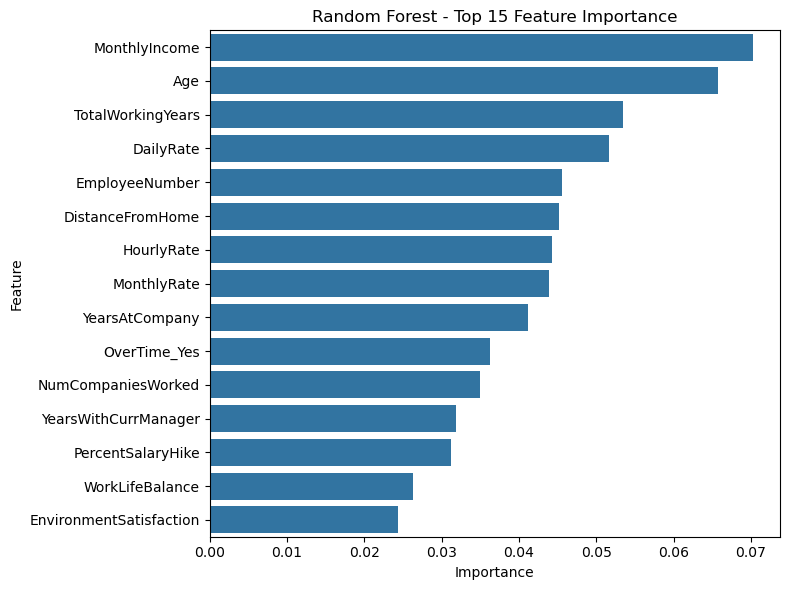

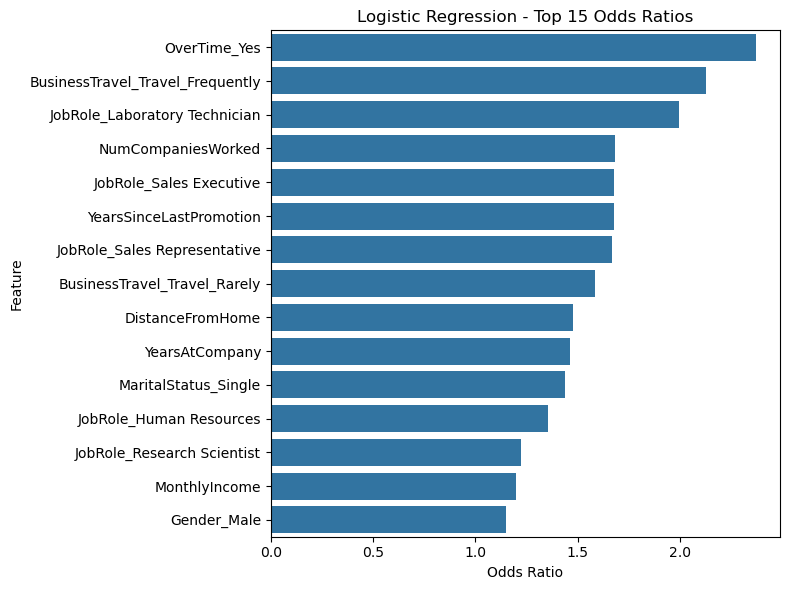

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest Importance
rf = models['Random Forest']
importances_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(8, 6))
sns.barplot(x=importances_rf.values, y=importances_rf.index)
plt.title('Random Forest - Top 15 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Logistic Regression Odds Ratios
logit = models['Logistic Regression']
odds = pd.Series(np.exp(logit.coef_[0]), index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(8, 6))
sns.barplot(x=odds.values, y=odds.index)
plt.title('Logistic Regression - Top 15 Odds Ratios')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [73]:
# Top 15 from Random Forest
top_rf = importances_rf.index.tolist()
print("Random Forest Top 15 Features:")
for i, feat in enumerate(top_rf, 1):
    print(f"{i}. {feat}")

# Top 15 from Logistic Regression
top_logit = odds.index.tolist()
print("\nLogistic Regression Top 15 Features:")
for i, feat in enumerate(top_logit, 1):
    print(f"{i}. {feat}")

Random Forest Top 15 Features:
1. MonthlyIncome
2. Age
3. TotalWorkingYears
4. DailyRate
5. EmployeeNumber
6. DistanceFromHome
7. HourlyRate
8. MonthlyRate
9. YearsAtCompany
10. OverTime_Yes
11. NumCompaniesWorked
12. YearsWithCurrManager
13. PercentSalaryHike
14. WorkLifeBalance
15. EnvironmentSatisfaction

Logistic Regression Top 15 Features:
1. OverTime_Yes
2. BusinessTravel_Travel_Frequently
3. JobRole_Laboratory Technician
4. NumCompaniesWorked
5. JobRole_Sales Executive
6. YearsSinceLastPromotion
7. JobRole_Sales Representative
8. BusinessTravel_Travel_Rarely
9. DistanceFromHome
10. YearsAtCompany
11. MaritalStatus_Single
12. JobRole_Human Resources
13. JobRole_Research Scientist
14. MonthlyIncome
15. Gender_Male


## Interpretation

The plots above show the factors that most influence attrition in our models.  
For **Random Forest**, the top predictors were primarily numeric measures like `MonthlyIncome`, `Age`, `TotalWorkingYears`, `DailyRate`, and `DistanceFromHome`, along with categorical indicators like `OverTime_Yes`.  
For **Logistic Regression**, the top predictors leaned more toward categorical job- and travel-related factors such as `OverTime_Yes`, `BusinessTravel_Travel_Frequently`, and several `JobRole` categories, alongside numeric features like `NumCompaniesWorked`, `DistanceFromHome`, and `MonthlyIncome`.

### How to read these results
- **Logistic Regression**: Positive coefficients (odds ratios > 1) increase the odds of attrition; negative coefficients (odds ratios < 1) decrease the odds.
- **Random Forest**: Higher importance scores indicate greater usefulness for splitting the data to predict attrition, but they do not directly indicate whether the feature increases or decreases risk.

### Key actionable insights
- `OverTime_Yes` is the strongest signal in both models — suggesting that overtime is highly associated with higher attrition risk.
- Travel frequency (`BusinessTravel_Travel_Frequently`) and certain job roles (e.g., `Laboratory Technician`, `Sales Executive`, `Sales Representative`) appear strongly in the Logistic model, indicating specific occupational or lifestyle factors linked to turnover.
- Compensation factors (`MonthlyIncome`, `PercentSalaryHike`) and career stability measures (`YearsAtCompany`, `YearsSinceLastPromotion`, `NumCompaniesWorked`) are also influential, hinting that pay satisfaction and career progression are important levers.
- Commute length (`DistanceFromHome`) consistently appears in both models, suggesting that reducing commute time (via relocation, remote work, or flexible scheduling) could improve retention.
